# ML Experiments

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
# NOTE: This library isn't yet available publicly!
from nd_learn.api import *
from nd_learn.api.sklearn import SKLEst, SKLOp

import lightgbm as lgb

In [3]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [4]:
from m5.metrics import get_weights, get_rmsse, get_wrmsse, wrmsse_per_level, wrmsse_total

## Prepare Data

### Load

In [5]:
ds_all = load_ds()

In [6]:
ds = ds_all.where(ds_all['historic'], drop=True).drop(["historic", "future"])
# Fix dtype changes due to "where" mask
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Fixes and checks

Fill the price for when we don't know it:

In [7]:
ds['price'] = ds['price'].ffill(dim="date").bfill(dim="date")

Check that all values are nonnegative:

In [8]:
(ds<0).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

Check that we don't have any nulls in our data:

In [9]:
ds.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

### Create Features

We will calculate features now, to avoid having to create a pipeline.
(It's not available in nd_learn yet, and I don't have enough time to code it)

In [10]:
# raw_ds = ds.copy()

We can't use target lags directly, because we must do a prediction many steps ahead!

Categorical features (as integers, because LightGBM can encode them natively)

In [11]:
ds.coords['category'] = np.unique(ds['cat_id'])
ds.coords['department'] = np.unique(ds['dept_id'])
ds.coords['state'] = np.unique(ds['state_id'])
ds.coords['store'] = np.unique(ds['store_id'])
ds.coords['item'] = np.unique(ds['item_id'])

In [12]:
def get_feat(ds, a: str, b: str) -> xr.DataArray:
    q = (ds[a] == ds[b])
    q.coords[b] = np.arange(len(q[b]))
    return q.idxmax(dim=b)

In [13]:
ds["feat_category"] = get_feat(ds, 'cat_id', 'category')
ds["feat_department"] = get_feat(ds, 'dept_id', 'department')
ds["feat_item"] = get_feat(ds, 'item_id', 'item')
ds["feat_state"] = get_feat(ds, 'state_id', 'state')
ds["feat_store"] = get_feat(ds, 'store_id', 'store')

Event features (there can be more than 1 event, but we'll take the first one & save number of them)

In [14]:
new_ev = xr.Dataset(
    coords={
        "event_name": ("event_name", ["(No Event)"]),
        "event_type": ("event_name", ["(No Event)"]),
    },
)
ds = xr.merge([new_ev, ds])

In [15]:
ds['n_events'] = ds['event'].sum(dim='event_name')
ds['event_ohe'] = ds['event'].fillna(ds['n_events']==0).astype(int)
del ds['event']

In [16]:
ds['feat_event'] = (ds['event_ohe'] * ds['event_name']).any(dim='event_name')
ds['feat_event'] = ds['feat_event'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_event', 'event_name')
q = q.where(~ds['feat_event'].isnull(), 0)
ds['feat_event'] = q

In [17]:
ds.coords['etype'] = np.unique(ds['event_type'])

In [18]:
ds['feat_etype'] = (ds['event_ohe'] * ds['event_type']).any(dim='event_name')
ds['feat_etype'] = ds['feat_etype'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_etype', 'etype')
q = q.where(~ds['feat_etype'].isnull(), 0)
ds['feat_etype'] = q

Remove `"event"/"event_ohe"` due to memory concerns :)

In [19]:
del ds['event_ohe']  # This is problematic in terms of memory usage

Lead/Lag for nearby events (e.g. people buy up for events):

In [20]:
leads = [1, 2]
_ds_leads = []
for i in leads:
    _ds_leads.append(ds["n_events"].shift(date=-i, fill_value=0).astype(int).expand_dims({"lead": i}))
ds["n_events_future"] = xr.concat(_ds_leads, dim="lead")
    
lags = [1]
_ds_lags = []
for i in lags:
    _ds_lags.append(ds["n_events"].shift(date=i, fill_value=0).astype(int).expand_dims({"lag": i}))
ds["n_events_past"] = xr.concat(_ds_lags, dim="lag")

Get sales for 1 year ago

In [21]:
_r1 = ds['sales'].shift({"date": 365}, fill_value=0).rolling({'date': 5}, min_periods=1, center=False)

In [22]:
ds['sales_year_ago_mean'] = _r1.mean()
ds['sales_year_ago_max'] = _r1.max()
ds['sales_year_ago_min'] = _r1.min()

Remove "year" to prevent some overfitting

In [ ]:
del ds["year"]

Preview our dataset

In [23]:
ds

<xarray.Dataset>
Dimensions:              (category: 3, date: 1941, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 3, state: 3, store: 10, store_id: 10)
Coordinates: (12/14)
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    ...                   ...
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
Dimensions without coordinates: lag, lead
Data variables: (12/19)
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 1 2 3 4 5 6 7 1 2
    month                (date) int64 1 1 1 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5
    year                 (date) int64 2011 2011 2011 2011 ... 2016 2016 2016
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ...                   ...
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 0 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.4 0.4
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0

### Split into training and validation

Let's train until 2016, and validate on the last few months.

In [24]:
dates_train = slice(None, '2015-12-31')
dates_valid = slice('2016-01-01', None)

ds_train = ds.sel({"date": slice(None, '2015-12-31')})

In [25]:
ds_train

<xarray.Dataset>
Dimensions:              (category: 3, date: 1798, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 3, state: 3, store: 10, store_id: 10)
Coordinates: (12/14)
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    ...                   ...
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
Dimensions without coordinates: lag, lead
Data variables: (12/19)
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 5 6 7 1 2 3 4 5 6
    month                (date) int64 1 1 1 2 2 2 2 2 ... 12 12 12 12 12 12 12
    year                 (date) int64 2011 2011 2011 2011 ... 2015 2015 2015
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ...                   ...
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 2 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 1 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 1 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.2 0.2
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0

## ML Model

### Fit

Train on a subset of data (1 month while testing):

In [26]:
only_test = False

In [27]:
if only_test:
    # Only December
    xy1 = ds_train.sel(date=slice("2015-12-01", "2015-12-31"))
else:
    # All of 2014 and 2015
    xy1 = ds_train.sel(date=slice("2014-01-01", "2015-12-31"))

Fit a LightGBM model (minimal hand-tuning):

In [28]:
# Select categorical feature names
my_cats = [
    "wday",
    "month",
    "feat_category",
    "feat_department",
    "feat_item",
    "feat_state",
    "feat_store",
    "feat_event",
    "feat_etype",
]

In [29]:
_lgb_model = lgb.LGBMRegressor(
    objective="poisson",
    n_estimators=1000,
    max_depth=4,
    colsample_bytree=0.9,
    # categorical_feature='name:'+','.join(my_cats),
)
est = SKLEst(_lgb_model, targets="sales", extra_fit_kwargs={"categorical_feature": my_cats})

In [31]:
mdl, xy1_hat = est.fit_transform(xy1)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


In [32]:
xy1_hat[['sales', 'sales_hat']]

<xarray.Dataset>
Dimensions:    (date: 730, item_id: 3049, store_id: 10)
Coordinates:
  * date       (date) datetime64[ns] 2014-01-01 2014-01-02 ... 2015-12-31
  * item_id    (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * store_id   (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    cat_id     (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id    (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
    state_id   (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
Data variables:
    sales      (item_id, store_id, date) int64 0 0 0 0 0 0 0 0 ... 0 1 0 0 0 0 0
    sales_hat  (date, item_id, store_id) float64 0.4791 0.3146 ... 0.1443 0.1303

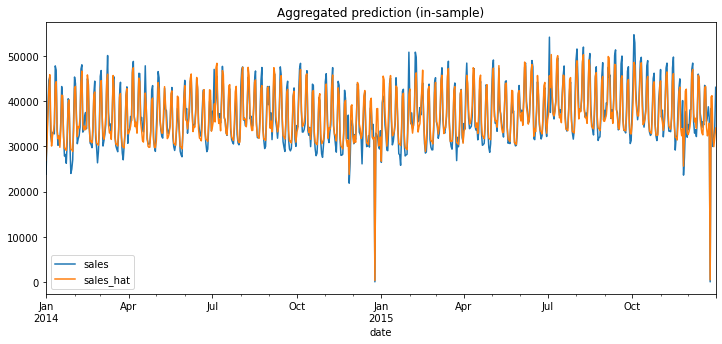

In [33]:
xy1_agg = xy1_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (in-sample)")
xy1_agg.to_dataframe().plot.line(ax=ax)
fig;

### Validate

In [34]:
xy2 = ds.sel(date=slice("2016-01-01", None))

In [35]:
xy2_hat = mdl.transform(xy2)

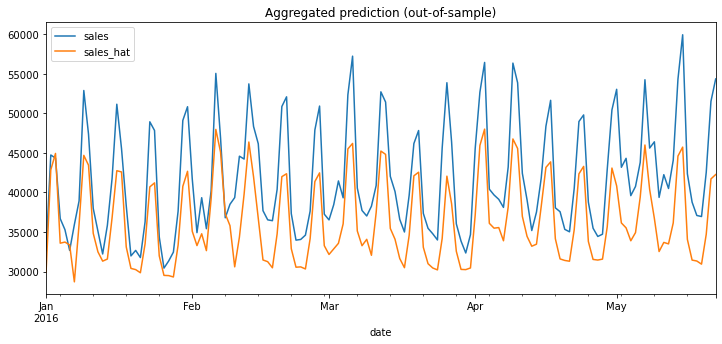

In [36]:
xy2_agg = xy2_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (out-of-sample)")
xy2_agg.to_dataframe().plot.line(ax=ax)
fig;

### Calculate error

The denominator is the MSE for the naive (1-step-ahead) forecast:

$$
mse_{naive} = \frac{1}{n-1} \sum_{t=2}^{n}{(Y_t-Y_{t-1})^2}
$$

We calculate error only after the first non-zero demand was observed.

The numerator is the MSE of your prediction, on the validation set:

$$
mse_{pred} = \frac{1}{h} \sum_{t=n+1}^{n+h} {(Y_t - \hat{Y_t})^2}
$$


The weights are just the value of sales during the last 28 days:

$$
w_i = \sum_{t=n-27}^{n}{Y_t \cdot price_t}
$$

Putting it all together, we get the Root Mean Squared Scaled Error (RMSSE):

$$
RMSSE = \sqrt{\frac{mse_{pred}}{mse_{naive}}}
$$

The weights are used to calculate the final metric (over all series):

$$
WRMSSE = \sum_{i=1}^{42840} {w_i * RMSSE_i}
$$

In [37]:
get_wrmsse(xy1, xy2_hat, t_hat="sales_hat")

0.9742927330820393

Note that an error greater than 1 means the forecast is worse than a 1-step-ahead naive/random walk forecast.
However, a 1-step-ahead forecast is impossible to use, because the forecast period is more than 1 day ahead.

In [38]:
errors_per_level = wrmsse_per_level(xy1, xy2_hat, t_hat="sales_hat")
errors_per_level

total            0.973259
state            1.065091
store            0.974293
cat              0.962062
dept             1.009826
state-cat        0.931078
state-dept       0.987953
store-cat        0.962062
store-dept       1.009826
product          0.974293
product-state    1.065091
product-store    0.974293
dtype: float64

This is the final error that would be shown on the leaderboard:

In [39]:
# result = wrmsse_total(xy1, xy2_hat, t_hat="sales_hat")
result = errors_per_level.mean()
result

0.9907605813228346

### Investigate model

In [40]:
mdl

SKLOp(sk_obj=LGBMRegressor(colsample_bytree=0.9, max_depth=4, n_estimators=1000,
              objective='poisson'), predictors=(ConstVS(names=['price', 'wday', 'month', 'year', 'snap', 'feat_category', 'feat_department', 'feat_item', 'feat_state', 'feat_store', 'n_events', 'feat_event', 'feat_etype', 'n_events_future', 'n_events_past', 'sales_year_ago_mean', 'sales_year_ago_max', 'sales_year_ago_min']) - ConstVS(names=['sales'])), dims_obs=['date', 'item_id', 'store_id'], targets=['sales'], extra_predict_kwargs={})

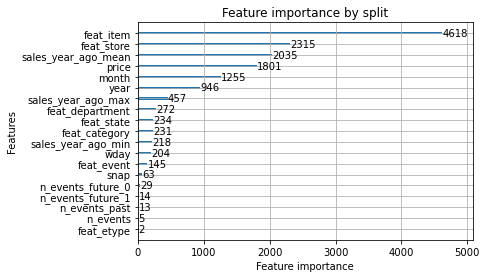

In [41]:
lgb.plot_importance(mdl.sk_obj, importance_type="split", title="Feature importance by split");

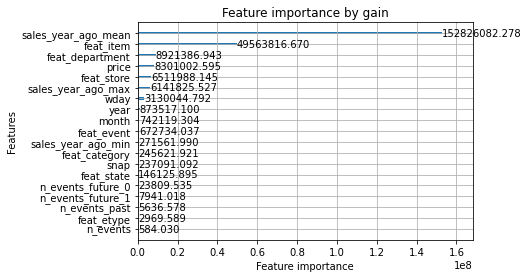

In [42]:
lgb.plot_importance(mdl.sk_obj, importance_type="gain", title="Feature importance by gain");